# PROJECT

**NOME:** Christian

**COGNOME:** Uccheddu

**MATRICOLA:** 800428

> This project is based on the code of Prof. Samuel Albani left during the lessons.

First the necessary libraries are imported in which the relative versions are also printed so that everything is reproducible.

In [111]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import seaborn
from pylab import *
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pmdarima as pm
import statsmodels

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib
import cartopy
import xarray as xr

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

pd.options.mode.chained_assignment = None

print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)
print("Cartopy version:",cartopy.__version__)
print("Geoandas version:",gpd.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Scipy version:",scipy.__version__)
print("Seaborn version:",sns.__version__)
print("Xarray version:",xr.__version__)
print("Pmdarima version:",pm.__version__)
print("Statsmodels version:",statsmodels.__version__)

Pandas version: 1.2.3
Numpy version: 1.19.2
Cartopy version: 0.18.0
Geoandas version: 0.8.1
Matplotlib version: 3.3.4
Scipy version: 1.6.1
Seaborn version: 0.11.1
Xarray version: 0.17.0
Pmdarima version: 1.8.0
Statsmodels version: 0.12.2


## Import data

At this point I import the 4 files that contain the three models. In particular, the last model is divided into two files which will then be concatenated to have a single model.

In [2]:
modfile='dati/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
modfile2='dati/ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc'
modfile3='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc'
modfile4='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc'

Now I extract the time series that we will need to visualize the data on graphs. I also concatenate the third and fourth time series into a single time series.

In [3]:
d1d = xr.open_dataset(modfile)
ts1 = d1d.ts  

d2d = xr.open_dataset(modfile2)
ts2 = d2d.ts  

d3d = xr.open_dataset(modfile3)
ts3 = d3d.ts  

d4d = xr.open_dataset(modfile4)
ts4 = d4d.ts  

m5 = xr.concat([ts3, ts4], dim = "time")

I make a plot of the means of the three time series so that I can visualize them on a map. In particular they have been colored with the "coolwarm" colormap which gives a good idea of which areas are warmer than others. I leave all three in the same figure using matplotlib's **gridspec** which allows you to define fully customizable grids.

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


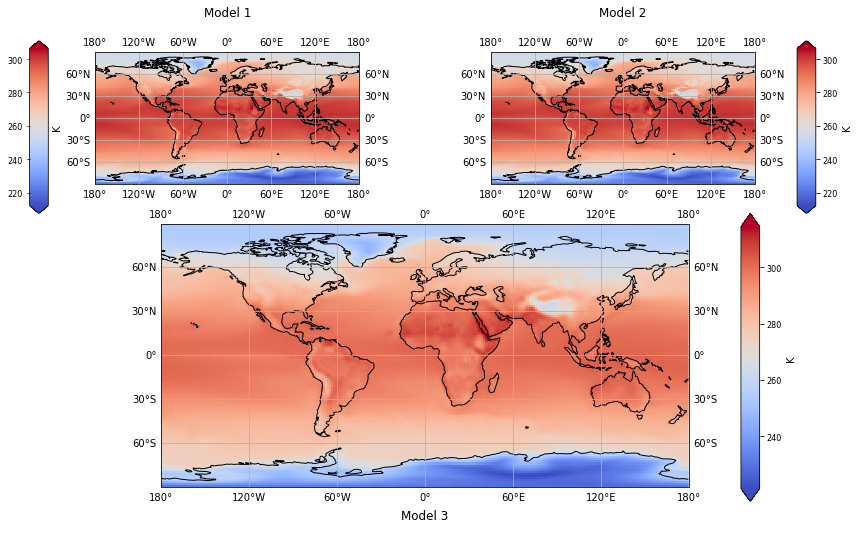

In [4]:
# Define the figure and the grid to fill with the three different plot
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 2], hspace = 0.2)

# Define the color map
cmap = mpl.cm.coolwarm

# Plot of the first time series
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_title('Model 1\n')
ax0.set_global()
mm0 = ax0.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax0.coastlines()
ax0.gridlines(draw_labels=True)
cbar_ax0 = fig.add_axes([0.09, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar0 = fig.colorbar(mm0, cax=cbar_ax0, extend='both', orientation='vertical')
cbar0.set_label('K')
cbar0.ax.tick_params(labelsize=8)
cbar_ax0.yaxis.tick_left()

# Plot of the second time series
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax1.set_title('Model 2\n')
ax1.set_global()
mm1 = ax1.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax1.coastlines()
ax1.gridlines(draw_labels=True)
cbar_ax1 = fig.add_axes([0.91, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar1 = fig.colorbar(mm1, cax=cbar_ax1, extend='both', orientation='vertical')
cbar1.set_label('K')
cbar1.ax.tick_params(labelsize=8)

# Plot of the third time series
ax2 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
ax2.set_title("Model 3\n", y=-0.2)
ax2.set_global()
mm2 = ax2.pcolormesh(m5.lon, m5.lat, m5.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap )  
ax2.coastlines()
ax2.gridlines(draw_labels=True)
cbar_ax2 = fig.add_axes([0.85, 0.1, 0.02, 0.50]) #[left, bottom, width, height]
cbar2 = fig.colorbar(mm2, cax=cbar_ax2, extend='both', orientation='vertical')
cbar2.set_label('K')
cbar2.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

At this point I do the regridding operation bringing all three time series to a single grid in order to create the ensemble model in a simpler way.

In [5]:
ts1_regridded = ts1.copy()
ts2_regridded = ts2.interp(lat=ts1.lat, lon=ts1.lon, method='linear')
ts3_regridded = m5.interp(lat=ts1.lat, lon=ts1.lon, method='linear')

First, I separately extrapolate the three time series by averaging along the time dimension by aggregating by year. Subsequently I aggregate these three time series spatially (always distinctly) in order to have a single value for each year for each time series.


In [6]:
ens_mean_month = np.nanmean([ts1_regridded.mean(("lon", "lat")), ts2_regridded.mean(("lon", "lat")), ts3_regridded.mean(("lon", "lat"))], axis=0)

In [7]:
ens_month = pd.concat([pd.Series(ts1_regridded.time, name = "time"), pd.Series(ens_mean_month, name = "Ensemble mean")], axis = 1, ignore_index = True)
ens_month.columns = ['time', 'Ensemble historical']
ens_month['time'] = pd.to_datetime(ens_month['time'], format = "%Y-%m-%d %H:%M:%S")
ens_month = ens_month[ens_month['time'].dt.year >= 1901]
ens_month['year'] = ens_month['time'].dt.year
ens_month['month'] = ens_month['time'].dt.month
ens_month.drop("time", axis = 1, inplace = True)

ens_month.head()

,Ensemble historical,year,month
612,277.620591,1901,1
613,276.748314,1901,2
614,276.547885,1901,3
615,277.742982,1901,4
616,279.477199,1901,5


We keep the historical series of monthly anomalies since working with Machine Learning techniques it is better to have more data.

In [8]:
ref_month = ens_month.loc[(ens_month['year'] >= 1961) & (ens_month['year'] <= 1990)].groupby("month").mean().reset_index().drop("year", axis = 1)
ref_month.columns = ['month', 'reference temperature']
ref_month

,month,reference temperature
0,1,277.564074
1,2,276.982217
2,3,276.806702
3,4,277.878794
4,5,279.670381
5,6,281.223710
6,7,281.735931
7,8,281.356015
8,9,280.205231
9,10,279.032454


In [9]:
anomaly_month = pd.merge(ens_month, ref_month, on = "month", how = "inner")
anomaly_month['anomaly'] = anomaly_month['Ensemble historical'] - anomaly_month['reference temperature']
anomaly_month = anomaly_month.sort_values(['year', 'month']).reset_index().drop("index", axis = 1)

I merge the two datasets in order to make the difference with the corresponding month and have the final dataset that contains the historical series of anomalies for each year.

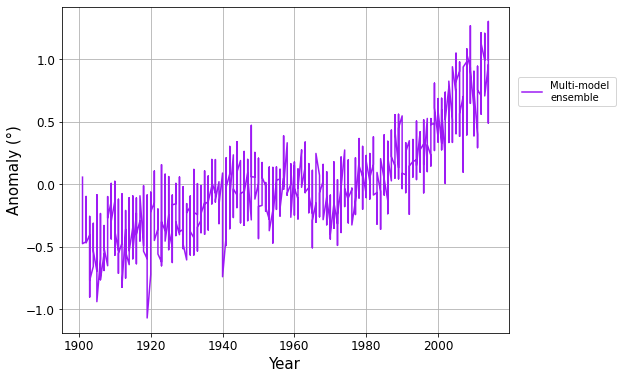

In [10]:
plt.figure(figsize = (8,6))

p1, = plt.plot(anomaly_month['year'], anomaly_month['anomaly'], color = "#9D1AF4", ls = "-")

plt.legend([p1], [ "Multi-model \nensemble"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

# Forecasting
## ARIMA

I build the dataframe so that it can be easily passed to the ARIMA models. In particular, I use the date in datetime format as an index and I keep the column **anomaly** the column in which the time series is present.

In [55]:
df = anomaly_month.copy()
df = df.drop(['Ensemble historical', 'reference temperature'], axis = 1)
df['date'] = pd.to_datetime(df['year'] * 10000 + df['month'] * 100 + 1, format="%Y%m%d")
df = df.drop(['year', 'month'], axis = 1)
df.set_index('date', inplace=True)

In [59]:
df

,anomaly
date,
1901-01-01,0.056517
1901-02-01,-0.233903
1901-03-01,-0.258817
1901-04-01,-0.135811
1901-05-01,-0.193181
...,...
2014-08-01,0.795933
2014-09-01,0.949292
2014-10-01,1.302075


I divide the time series into two parts: the train part which contains all the observations minus the last 3 years and the validation part which contains the last 3 years of observations so that you can compare the MSEs between the various models and decide which one is the best. Then I'll fit all the models among all the historical series and make the prediction for the next three years

In [60]:
df_train = df.iloc[:1332]
df_val = df.iloc[1332:]

We first decompose the time series with an additive method to see what trends, seasonality and residuals are like.

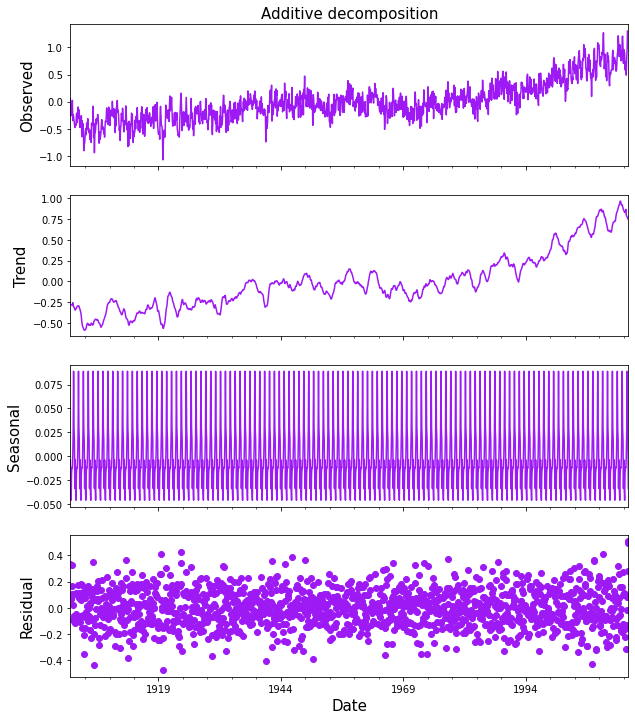

In [76]:
result_add = seasonal_decompose(df['anomaly'], model='additive', extrapolate_trend='freq')

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,12))

result_add.observed.plot(ax=axes[0], legend=False, color = "#9D1AF4")
axes[0].set_ylabel('Observed', fontsize = 15)
result_add.trend.plot(ax=axes[1], legend=False, color = "#9D1AF4")
axes[1].set_ylabel('Trend', fontsize = 15)
result_add.seasonal.plot(ax=axes[2], legend=False, color = "#9D1AF4")
axes[2].set_ylabel('Seasonal', fontsize = 15)
result_add.resid.plot(ax=axes[3], legend=False, style='o', color = "#9D1AF4")
axes[3].set_ylabel('Residual', fontsize = 15)
axes[3].set_xlabel('Date', fontsize = 15)

axes[0].set_title("Additive decomposition", fontsize = 15)
plt.show()

We now use the autoarima function which allows to perform a grid search on the coefficients of the ARIMA model in order to test all the models. Subsequently, the one with the lowest AIC value is chosen.

In [15]:
smodel = pm.auto_arima(df_train['anomaly'], start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-193.433, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-642.596, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-917.955, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-193.950, Time=0.12 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-291.750, Time=0.23 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-916.231, Time=1.72 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-916.296, Time=5.92 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-575.140, Time=1.00 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-916.461, Time=10.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-739.468, Time=1.20 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-1012.713, Time=1.74 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=-342.697, Time=0.54 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=-1010.716, Time=3.92 sec
 ARIMA(0,0,2)(0,1,2)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1332
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 12)   Log Likelihood                 527.094
Date:                              Mon, 26 Apr 2021   AIC                          -1042.188
Time:                                      16:23:30   BIC                          -1011.076
Sample:                                           0   HQIC                         -1030.523
                                             - 1332                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.001      8.029      0.000       0.007       0.012
ma.L1          0.3390      0.028     12.253      0.000       0.285       0.393
ma.L2          0.2694      0.030      9.023      0.000       0.211       0.328
ma.L3          0.1443      0.027      5.425      0.000       0.092       0.196
ma.S.L12      -0.8515      0.015    -55.204      0.000      -0.882      -0.821
sigma2         0.0260      0.001     25.469      0.000       0.024       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.37   Prob(JB):                         0.25
Heteroskedasticity (H):               1.08   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As you can see from the output, the best model is the model ARIMA(0, 0, 3)(0, 1, 1)\[12\] in which all coefficients are statistically significant. We therefore expect good predictions from this model. We then generate the predictions for the last three years of our time series and see how it behaves in terms of MSE.

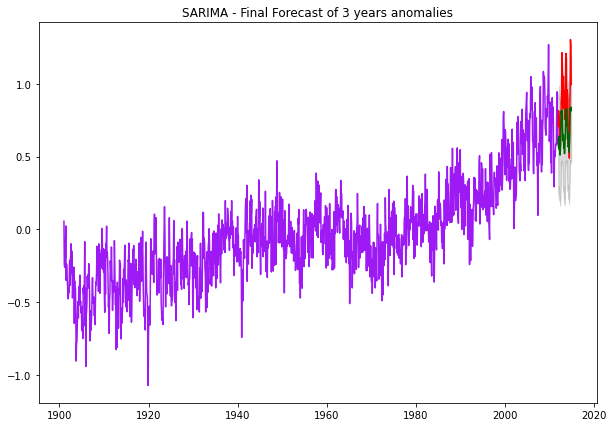

In [77]:
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_train['anomaly'].index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series_auto = pd.Series(fitted, index=index_of_fc)
lower_series_auto = pd.Series(confint[:, 0], index=index_of_fc)
upper_series_auto = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10, 7))

plt.plot(df_train['anomaly'], color = "#9D1AF4")
plt.plot(df_val['anomaly'], color='red')

plt.plot(fitted_series_auto, color='darkgreen')
plt.fill_between(lower_series_auto.index, 
                 lower_series_auto, 
                 upper_series_auto, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 3 years anomalies")
plt.show()

Lets' focus only on the predictions

In [170]:
plt.figure(figsize=(10, 7))

plt.plot(df_val['anomaly'], color='red', label = "True values")

plt.plot(fitted_series_auto, color='darkgreen', label = "Predicted values")
plt.fill_between(lower_series_auto.index, 
                 lower_series_auto, 
                 upper_series_auto, 
                 color='k', alpha=.15)
plt.ylabel("Anomalies", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.title("SARIMA - Final Forecast of 3 years anomalies", fontsize = 15)
plt.show()

KeyError: 'anomaly'

<Figure size 720x504 with 0 Axes>

As we can see, the model generates predictions that are comparable with the time series in terms of the confidence interval. However, it does not seem to be able to follow the growing trend of the time series well; so let's try to build another ARIMA model to make sure that the growing trend of the time series is better understood.

In [81]:
mse_autoarima = round(((df_val['anomaly'].values - fitted_series_auto.values)**2).mean(), 2)
print("MSE on auto ARIMA:", mse_autoarima)

MSE on auto ARIMA: 0.06


## Customized ARIMA

For the choice of the p, d, q coefficients to be inserted in a manually created ARIMA model, it is essential to study the PACFs of both the normal and delayed series. By counting the number of lags that leave the interval, in fact, it is possible to trace the correct coefficients to be entered.

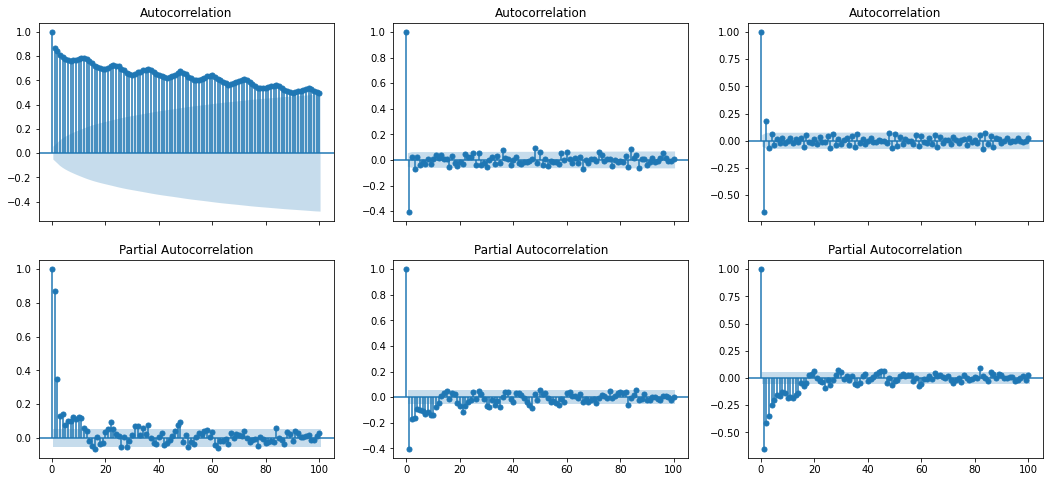

In [84]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize = (18,8))

plot_acf(df['anomaly'].dropna(),  lags=100, ax=axes[0,0])
plot_acf(df['anomaly'].diff().dropna(), lags=100, ax=axes[0,1])
plot_acf(df['anomaly'].diff().diff().dropna(), lags=100, ax=axes[0,2])

plot_pacf(df['anomaly'].dropna(),  lags=100, ax=axes[1,0])
plot_pacf(df['anomaly'].diff().dropna(), lags=100, ax=axes[1,1])
plot_pacf(df['anomaly'].diff().diff().dropna(), lags=100, ax=axes[1,2])

plt.show()

Sembra che ci voglia un AR(2), pensiamo già a come inserire dei regressori esterni, possibilmente come armoniche

In [109]:
model = ARIMA(df_train['anomaly'], order = (2, 0, 5), seasonal_order = (2,0,1, 12),trend = "ct", dates = df.index)
#model = pm.arima.ARIMA(df_train['anomaly'], order = [2, 0, 5], seasonal_order = [2,0,1, 12], trend = "t", dates = df.index)

res = model.fit()
print(res.summary())

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

                                     SARIMAX Results                                      
Dep. Variable:                            anomaly   No. Observations:                 1332
Model:             ARIMA(2, 0, 5)x(2, 0, [1], 12)   Log Likelihood                 300.259
Date:                            Mon, 26 Apr 2021   AIC                           -574.518
Time:                                    17:01:14   BIC                           -506.990
Sample:                                01-01-1901   HQIC                          -549.212
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4937      0.012    -41.703      0.000      -0.517      -0.470
x1             0.0007   1.48e-05   

In [110]:
res.conf_int()

,0,1
const,-0.516890,-0.470485
x1,0.000676,0.000734
ar.L1,-0.023311,0.023312
ar.L2,-0.024098,0.024099
ma.L1,-0.023311,0.023312
ma.L2,-0.024098,0.024099
ma.L3,-0.047861,0.047862
ma.L4,-0.045479,0.045479
ma.L5,-0.044794,0.044795
ar.S.L12,0.519062,0.859296


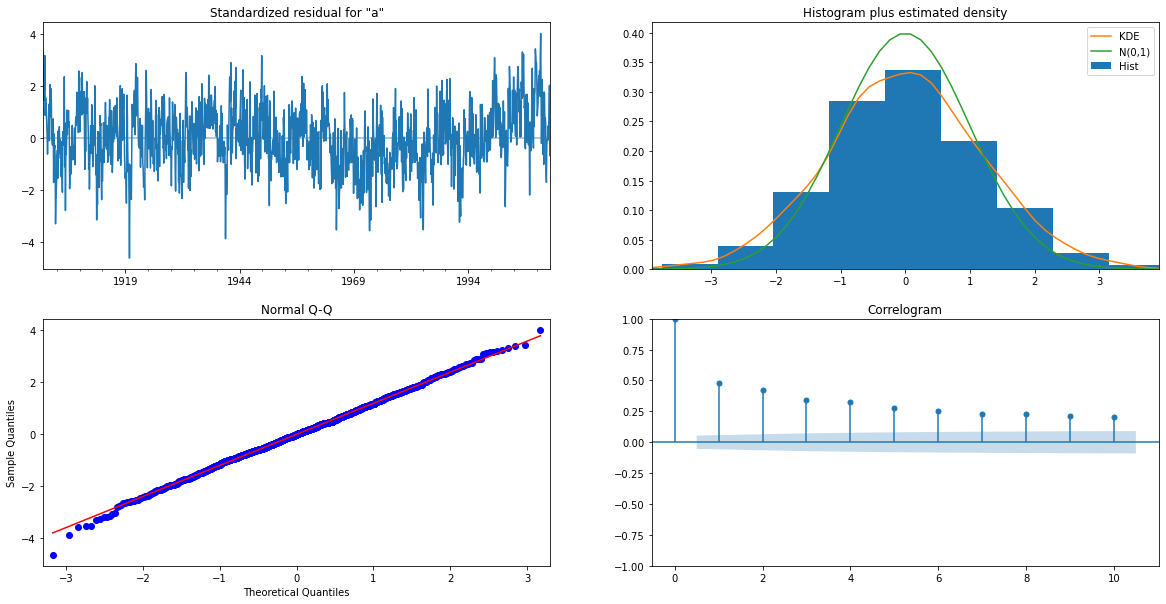

In [94]:
res.plot_diagnostics(figsize=(20,10))
plt.show()

C'è un forte ritardo sul primo, bisognerebbe aggiungere una differenziazione

In [105]:
n_periods = 36

fitted, confint = res.predict(n_periods = n_periods, return_conf_int = True)
index_of_fc = pd.date_range(df_train['anomaly'].index[-1], periods = n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index = index_of_fc)
lower_series = pd.Series(confint[:, 0], index = index_of_fc)
upper_series = pd.Series(confint[:, 1], index = index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(df_train['anomaly'])
plt.plot(df_val['anomaly'], color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 3 years anomalies")
plt.show()

ValueError: too many values to unpack (expected 2)

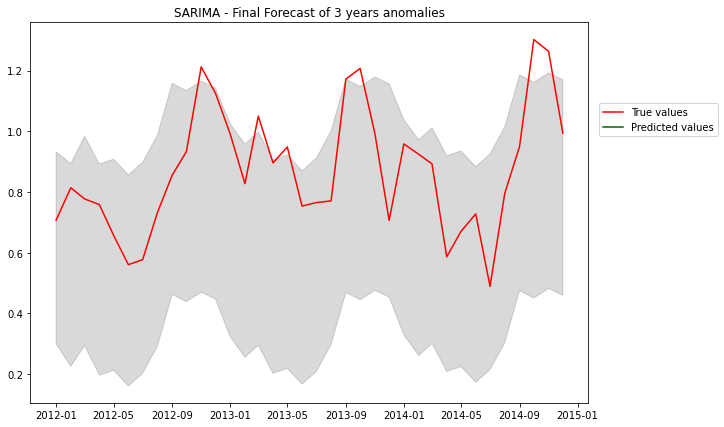

In [102]:
plt.figure(figsize=(10, 7))

plt.plot(df_val['anomaly'], color='red', label = "True values")

plt.plot(fitted_series, color='darkgreen', label = "Predicted values")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.ylabel("Anomalies", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.title("SARIMA - Final Forecast of 3 years anomalies", fontsize = 15)
plt.show()

In [97]:
mse_arima = round(((df_val['anomaly'].values - fitted_series.values)**2).mean(), 2)
print("MSE on customized ARIMA:", mse_arima)

MSE on customized ARIMA: 0.06


## Prophet FB

We now use Prophet FB which is the neural network for the prediction of time series made available by Facebook. To be able to use it, however, you must name the columns of the dataframe exactly as required. In particular, the dataset must have a column named "ds" which will contain the dates and a column named "y" which will contain the numeric values of the historical series.

In [112]:
df = anomaly_month.copy()
df = df.drop(['Ensemble historical', 'reference temperature'], axis = 1)
df['ds'] = pd.to_datetime(df['year'] * 10000 + df['month'] * 100 + 1, format="%Y%m%d")
df = df.drop(['year', 'month'], axis = 1)
df.columns = ['y', 'ds']

We manually define the last 36 observations (3 years) as the validation period in order to compare this result with the one obtained by the ARIMA models.

In [113]:
df_train = df.iloc[:1332]
df_val = df.iloc[1332:]

We set the default parameters for the model by changing only the type of seasonality; in fact, due to the nature of the historical series, we expect that there is an annual seasonality within the data which means that the results tend to be repeated every year.

In [114]:
model2 = Prophet(interval_width = 0.95, yearly_seasonality = True, weekly_seasonality = True, changepoint_prior_scale = 2) 
model2.add_seasonality(name='monthly', period = 365.5, fourier_order = 5, prior_scale = 0.02)
model2.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We manually create the forecast 36 months forward so that we can compare it with the validation period and have a measure of MSE.

In [115]:
future = model2.make_future_dataframe(freq='M', periods=36)

future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model2.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Let us now draw the predictions along the entire time series showing how the data is fitted

          ds      yhat  yhat_lower  yhat_upper
0 1901-01-01 -0.238752   -0.560142    0.088807
1 1901-02-01 -0.309236   -0.633167    0.021713
2 1901-03-01 -0.329828   -0.625371   -0.005624
3 1901-04-01 -0.271724   -0.597795    0.052126
4 1901-05-01 -0.269997   -0.577995    0.031558


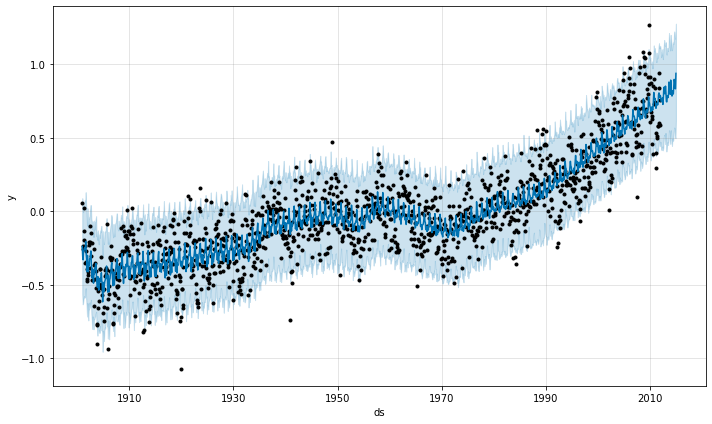

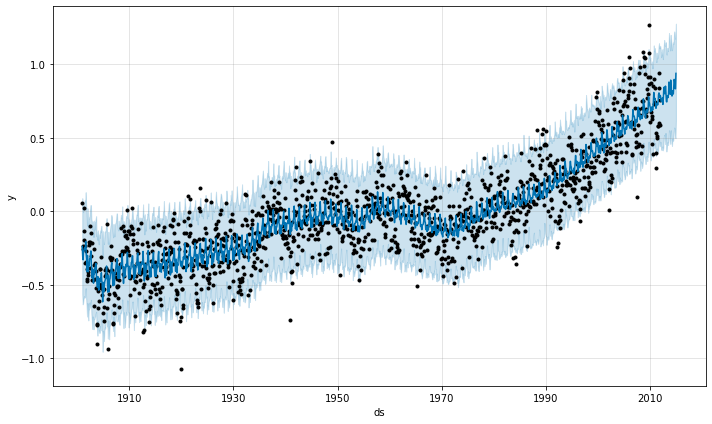

In [117]:
model2.plot(forecast)

Let's focus now only on the last 3 years.

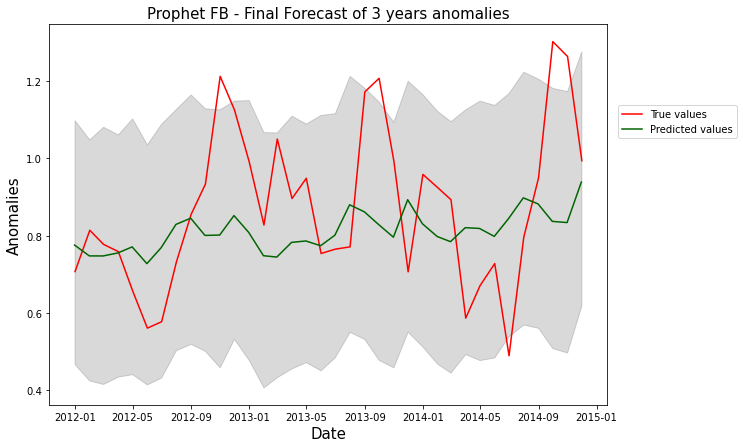

In [169]:
plt.figure(figsize=(10, 7))

plt.plot(df_val['ds'], df_val['y'], color='red', label = "True values")

plt.plot(forecast.iloc[1332:]['ds'], forecast.iloc[1332:]['yhat'], color='darkgreen', label = "Predicted values")

plt.fill_between(forecast.iloc[1332:]['ds'], 
                 forecast.iloc[1332:]['yhat_lower'], 
                 forecast.iloc[1332:]['yhat_upper'], 
                 color='k', alpha=.15)

plt.ylabel("Anomalies", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.title("Prophet FB - Final Forecast of 3 years anomalies", fontsize = 15)
plt.show()

In [138]:
mse_prophet = round(((df_val['y'] - forecast.iloc[1332:]['yhat'])**2).mean(), 2)
print("MSE on Prophet FB:", mse_prophet)

MSE on Prophet FB: 0.04


As we can see this network performs much better than the ARIMA models both in terms of MSE and in visual terms. In fact, when working with time series it is always necessary to give a graphical interpretation of the data. In particular, this model seems to better capture the growing trend compared to the ARIMA models and almost all its forecasts 3 years forward are statistically compatible with the values that have actually been achieved.

## LSTM

Let's now move on to the first Deep Learning model. In particular, the first model consists of a bidirectional LSTM. In order to pass the data to this model, however, we must first fix it. 
We then create a **processData** function that allows us to put the time series in such a way that it is passable to a model of this type.

In [34]:
def processData(data, look_back, time_steps):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -time_steps +1):
        X.append(data[i:(i+look_back)].values)
        Y.append(data[(i+look_back):(i+look_back+time_steps)].values)
    return np.array(X),np.array(Y)

We first define the number of observations we want to predict (36) in order to pass it to the model.

In [123]:
time_steps = 36

test_size = time_steps * 2 
train_size = 1 - test_size

train, test = df.iloc[0:train_size-1], df.iloc[train_size-1:len(df)]

X_train, y_train = processData(train['y'],time_steps, time_steps)
X_test, y_test = processData(test['y'], time_steps, time_steps)

# Other operation to make data suitable to the model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [124]:
model_lstm = Sequential(
    [
            layers.Bidirectional(LSTM(units = 100, return_sequences=True)),
            layers.Dropout(0.2),
            layers.Bidirectional(LSTM(units = 50)),
            layers.Dropout(0.2),
            layers.Dense(time_steps, activation='linear')
    ])

We then compile the model using ADAM as an optimizer that allows to apply the Gradient Descent algorithm. In particular, we use a learning rate value of 0.001 in order to combine performance and execution times. We also launch the model over 30 epochs by applying early stopping algorithms to prevent over fitting.

In [132]:
model_lstm.compile(loss='mean_absolute_error', optimizer = keras.optimizers.Adam(0.001))

history_lstm = model_lstm.fit(X_train, y_train, epochs = 50, 
                              batch_size = 64, validation_split = 0.2, 
                              verbose = 1, shuffle = False)

Train on 980 samples, validate on 245 samples
Epoch 1/30
980/980 [==============================] - 4s 4ms/sample - loss: 0.1377 - val_loss: 0.3716
Epoch 2/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1481 - val_loss: 0.3227
Epoch 3/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1391 - val_loss: 0.3080
Epoch 4/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1374 - val_loss: 0.3272
Epoch 5/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1375 - val_loss: 0.3307
Epoch 6/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1368 - val_loss: 0.3332
Epoch 7/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1361 - val_loss: 0.3371
Epoch 8/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1360 - val_loss: 0.3415
Epoch 9/30
980/980 [==============================] - 1s 1ms/sample - loss: 0.1364 - val_loss: 0.3423
Epoch 10/30
980/980 [===============

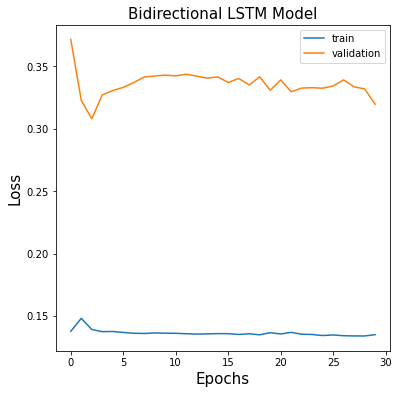

In [162]:
plt.figure(figsize=(6, 6))

plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='validation')
plt.title("Bidirectional LSTM Model", fontsize = 15)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)

plt.legend()

As we can see, there is a very strong overfitting component. This phenomenon was conceivable a priori since these networks have a very large number of parameters and therefore need a very large number of data to learn about that we do not have available.

In [135]:
y_pred_lstm = model_lstm.predict(X_test)

Recall that this type of network provides punctual predictions with no confidence interval, so what we can do is compare the MSE with the other models and make qualitative considerations.

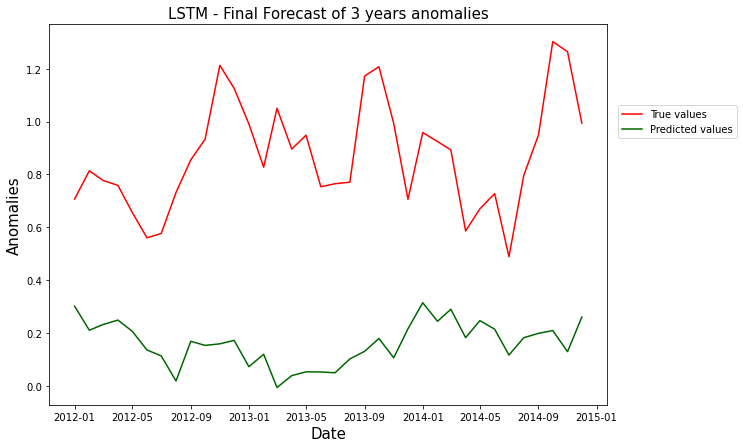

In [168]:
plt.figure(figsize=(10, 7))

plt.plot(df_val['ds'], df_val['y'], color='red', label = "True values")
plt.plot(df_val['ds'], y_pred_lstm.reshape(-1,1), color='darkgreen', label = "Predicted values")
plt.ylabel("Anomalies", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.title("LSTM - Final Forecast of 3 years anomalies", fontsize = 15)
plt.show()

Recall that this type of network provides punctual predictions with no confidence interval, so what we can do is compare the MSE with the other models and make qualitative considerations. From the graph we can therefore see how all the predictions underestimate the value that is then achieved of the time series. This mismatch in predictions can be explained by the fact that this type of networks require a large amount of data, which in this case we do not have.

In [142]:
mse_lstm = round(((df_val['y'].values - y_pred_lstm)**2).mean(),2)
print("MSE on Bidirectional LSTM:", mse_lstm)

MSE on Bidirectional LSTM: 0.55


As we expected, therefore, the MSE value of this network is much greater than the values of both the ARIMA models and the Prophet FB network (about an order of magnitude).

## CNN

Finally, the latest model tested is a CNN model adapted for time series forecasting. It is composed of a 1D Convolutional layer with 64 filters of 3 and relu activation, followed by a MaxPooling layer with a pool size of 3, a flatten layer and a dense layer. All this is followed by a Dropout layer and the last Denso layer for the prediction of the n = time_steps observations. As in the previous case, we do not expect significant performances since the problem of the small number of data persists.

In [151]:
model_cnn = Sequential(
    [
            layers.Conv1D(filters = 16, kernel_size = 3, activation='relu'),
            layers.MaxPooling1D(pool_size = 3),
            layers.Flatten(),
            layers.Dense(16, activation = 'relu'),
            layers.Dropout(0.2),
            layers.Dense(time_steps, activation='linear')
    ])

We then compile the model using ADAM as an optimizer that allows to apply the Gradient Descent algorithm. In particular, we use a learning rate value of 0.001 in order to combine performance and execution times. We also launch the model over 30 epochs by applying early stopping algorithms to prevent over fitting.

In [163]:
model_cnn.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

history_cnn = model_cnn.fit(X_train, y_train, epochs = 30, 
                            batch_size = 64, validation_split = 0.2,
                            verbose = 1, shuffle = False)

Train on 980 samples, validate on 245 samples
Epoch 1/30
980/980 [==============================] - 2s 2ms/sample - loss: 0.1338 - val_loss: 0.3734
Epoch 2/30
980/980 [==============================] - 0s 39us/sample - loss: 0.1358 - val_loss: 0.3571
Epoch 3/30
980/980 [==============================] - 0s 39us/sample - loss: 0.1354 - val_loss: 0.3734
Epoch 4/30
980/980 [==============================] - 0s 42us/sample - loss: 0.1349 - val_loss: 0.3636
Epoch 5/30
980/980 [==============================] - 0s 44us/sample - loss: 0.1340 - val_loss: 0.3670
Epoch 6/30
980/980 [==============================] - 0s 46us/sample - loss: 0.1359 - val_loss: 0.3579
Epoch 7/30
980/980 [==============================] - 0s 49us/sample - loss: 0.1344 - val_loss: 0.3584
Epoch 8/30
980/980 [==============================] - 0s 47us/sample - loss: 0.1349 - val_loss: 0.3626
Epoch 9/30
980/980 [==============================] - 0s 46us/sample - loss: 0.1331 - val_loss: 0.3579
Epoch 10/30
980/980 [=======

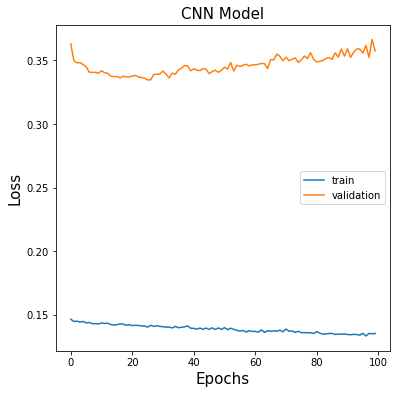

In [161]:
plt.figure(figsize=(6, 6))

plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='validation')
plt.title("CNN Model", fontsize = 15)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)

plt.legend()

As we can see, there is a very strong overfitting component. This phenomenon was conceivable a priori since these networks have a very large number of parameters and therefore need a very large number of data to learn about that we do not have available.

In [156]:
y_pred_cnn = model_cnn.predict(X_test)

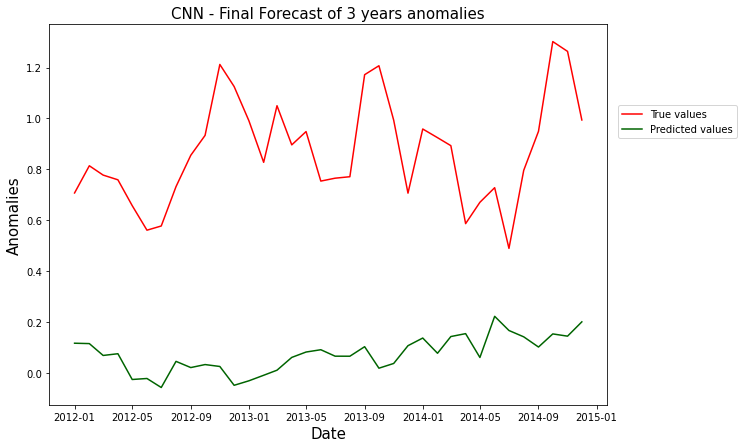

In [167]:
plt.figure(figsize=(10, 7))

plt.plot(df_val['ds'], df_val['y'], color='red', label = "True values")
plt.plot(df_val['ds'], y_pred_cnn.reshape(-1,1), color='darkgreen', label = "Predicted values")
plt.ylabel("Anomalies", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.title("CNN - Final Forecast of 3 years anomalies" , fontsize = 15)
plt.show()

As in the previous case, the predictions tend to always underestimate the values that actually exist

In [165]:
mse_cnn = round(((df_val['y'].values - y_pred_cnn)**2).mean(), 2)
print("MSE on Bidirectional LSTM:", mse_cnn)

MSE on Bidirectional LSTM: 0.68


As in the case of the LSTM network, the results of the predictions are not optimal and also in this case differ by about an order of magnitude compared to the results of Prophet and the ARIMA models. In fact, to ensure that this network works well, it would be necessary to have a large amount of data available which unfortunately we do not have.

## KNN

Proviamo a fare clustering

## COMPARISON

Faccio le comparazioni tra gli MSE delle serie storiche